# SEC Data Collection
### Steps
1. Get urls for filings
2. Get company info and filter by marketcap
4. Download filings
5. Clean filings
6. Diff filings

In [ ]:
# 1. Get urls for 2019 Q3 filings and more recent

import edgar
import os

data_dir = os.path.join(os.getcwd(), 'data/sec')
# os.mkdir(data_dir)
indices_dir = os.path.join(data_dir, 'indices')
# os.mkdir(indices_dir)
# edgar.download_index(indices_dir, 2019, False)

In [ ]:
"""
2. Get company info and filter by marketcap
    a. Get list of ticker symbols
    b. Join symbols with filings dataset on cik
    c. Get marketcap for each
    d. Get sector for each
    e. Filter by marketcap
""" 
# Reference code: https://github.com/PlatorSolutions/quarterly-earnings-machine-learning-algo/blob/master/download_raw_html.py
import pandas as pd
import os

filings_dir = os.path.join(data_dir, 'filings')
# os.mkdir(filings_dir)

df = pd.DataFrame()
for tsv in os.listdir(indices_dir):
    if '.ipynb_checkpoints' in tsv:
        continue
    path = os.path.join(indices_dir, tsv)
    df_ext = pd.read_csv(path, delimiter='|', names=['cik', 'name', 'type', 'date', 'text_uri', 'index_url'])
    df = df.append(df_ext)
    
df_10Q = df[df['type'] == '10-Q'].reset_index()
df_10Q['date'] = pd.to_datetime(df_10Q['date'], format='%Y-%m-%d')

In [ ]:
import requests
import numpy as np

def cik_to_ticker(cik):
    endpoint = f'https://mapping-api.herokuapp.com/cik/{cik}'
    res = requests.get(endpoint)
    if len(res.json()) < 1:
        return np.nan
    return res.json()[0]['ticker']

In [ ]:
def ticker_to_company_info(ticker):
    key_id = 'AKQLE29QN0JRVM0Y786Y'
    endpoint = f'https://api.polygon.io/v1/meta/symbols/{ticker}/company?apiKey={key_id}'
    res = requests.get(endpoint)
    if res.status_code == 200 and 'json' in res.headers['Content-Type']:
        return res.json()
    else:
        return np.nan

In [ ]:
df_10Q['ticker'] = df_10Q['cik'].apply(lambda cik: cik_to_ticker(cik))

In [ ]:
import time

df_10Q = df_10Q.dropna()
company_info_list = df_10Q['ticker'].apply(lambda ticker: ticker_to_company_info(ticker))

In [ ]:
bool_index = company_info_list.notna()
company_info_list = company_info_list.loc[bool_index]
df_10Q = df_10Q.loc[bool_index].reset_index()

In [ ]:
df_10Q['marketcap'] = company_info_list.apply(lambda info: info['marketcap'])
df_10Q['sector'] = company_info_list.apply(lambda info: info['sector'])
df_10Q = df_10Q.dropna()

In [ ]:
df_10Q['marketcap'].describe()

In [ ]:
df_10Q = df_10Q.loc[df_10Q['marketcap'] >= 1e9]

In [ ]:
df_10Q = df_10Q.reset_index(drop=True).drop(['level_0', 'index'], axis=1)

In [ ]:
# 3. Download filings
import requests
from bs4 import BeautifulSoup

filing_dir = os.path.join(data_dir, 'raw_filings')
# os.mkdir(filing_dir)

sec_url = 'https://www.sec.gov/Archives'
min_change = 1
curr_change = 0
path_list = []
for i, filing in df_10Q.iterrows():
    if i > 0:
        curr_val = (i / len(df_10Q)) * 100
        curr_change += curr_val - (((i - 1) / len(df_10Q)) * 100)
        if curr_change >= min_change:
            print(f'{curr_val:.2f}% downloaded')
            curr_change = 0
    
    # Get page
    path = os.path.join(sec_url, filing['index_url'])
    res = requests.get(path)
    soup = BeautifulSoup(res.content, 'lxml')
    
    # Find download href
    files_table = soup.find('table', {'class': 'tableFile', 'summary': 'Document Format Files'})
    anchor_element = None
    for row in files_table.find_all('tr'):
        e = row.find_all('td')
        if len(e) >= 4 and e[3].text == filing['type']:
            anchor_element = e[2].find('a', href=True)
            break
    
    anchor = anchor_element['href']
    name = anchor_element.text
    acceptance_date = soup.find('div', attrs={'class': 'infoHead'}, text='Accepted').findNext('div', {'class': 'info'}).text

    if 'ix?' in anchor:
        anchor = '/' + '/'.join(anchor.split('/')[2:])
    
    # Download
    sec_base = 'https://www.sec.gov'
    download_res = requests.get(sec_base + anchor)
    
    # Save
    file_name = '_'.join([filing['name'].replace(' ', '').replace('/', ''), filing['type'], filing['date'].strftime('%Y-%m')]) + '.htm'
    file_path = os.path.join(filing_dir, file_name)
    with open(file_path, 'w') as file:
        file.write(download_res.text)
    
    path_list.append(file_path)

In [ ]:
df_10Q['path'] = path_list

In [ ]:
# 5. Clean filings
import html
import multiprocessing as mp
import re
from functools import partial

def removeInnerLinks(soup):
    [i.extract() for i in soup.find_all('a', href=True) if len(i['href']) > 0 and i['href'][0] == '#']
    return soup

def remove_xbrli(soup):
    [x.extract() for x in soup.find_all(re.compile("^xbrli:"))]
    return soup

def removeNumericalTables(soup):

    def GetDigitPercentage(tablestring):
        if len(tablestring) > 0.0:
            numbers = sum([char.isdigit() for char in tablestring])
            length = len(tablestring)
            return numbers / length
        else:
            return 1

    def containsBgColor(table):
        for row in table.find_all('tr'):
            colored = 'background-color' in str(row) or 'bgcolor' in str(row)
            if colored:
                return True
        return False

    [x.extract() for x in soup.find_all('table') if containsBgColor(x)]

    [x.extract() for x in soup.find_all('table') if GetDigitPercentage(x.get_text()) > 0.15]

    return soup

def prep_text(text):
    soup = BeautifulSoup(html.unescape(re.sub(r'\s+', ' ', text)), "lxml")

    soup = remove_xbrli(soup)

    soup = removeInnerLinks(soup)

    soup = removeNumericalTables(soup)

    [x.unwrap() for x in soup.find_all(['span', 'font', 'b', 'i', 'u', 'strong'])]

    soup.smooth()

    text = soup.get_text(separator="\n", strip=True)

    stop_words = set(['HUNDRED', 'THOUSAND', 'MILLION', 'BILLION', 'TRILLION', 'DATE', 'ANNUAL', 'ANNUALLY', 'ANNUM', 'YEAR', 'YEARLY', 'QUARTER', 'QUARTERLY', 'QTR', 'MONTH', 'MONTHLY', 'WEEK', 'WEEKLY', 'DAY', 'DAILY', 'JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'DEC', 'MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY', 'ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX', 'SEVEN', 'EIGHT', 'NINE', 'TEN', 'ELEVEN', 'TWELVE', 'THIRTEEN', 'FOURTEEN', 'FIFTEEN', 'SIXTEEN', 'SEVENTEEN', 'EIGHTEEN', 'NINETEEN', 'TWENTY', 'THIRTY', 'FORTY', 'FIFTY', 'SIXTY', 'SEVENTY', 'EIGHTY', 'NINETY', 'FIRST', 'SECOND', 'THIRD', 'FOURTH', 'FIFTH', 'SIXTH', 'SEVENTH', 'EIGHTH', 'NINTH', 'TENTH'])
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*', re.IGNORECASE)
    text = pattern.sub('', text)

    pattern = re.compile('\s[^a-zA-Z\s]+?(?=(\.*\s))')
    text = pattern.sub('', text)

    text = '\n'.join(
        filter(lambda line: len(line) > 0 and (sum(i.isalpha() for i in line) / len(line) > .5), text.splitlines()))

    return text


def prep_file(path):
    with open(path) as f:
        text = prep_text(f.read())
    return text

def saveBag(c, old_file_name):
    file_name = f'cleaned_{old_file_name.replace(".htm", ".txt")}'
    file_path = os.path.join(cleaned_filings_dir, file_name)
    with open(file_path, 'w') as file:
        file.write(c)

In [ ]:
import os
from bs4 import BeautifulSoup

cleaned_filings_dir = os.path.join(data_dir, 'cleaned_filings')
# os.mkdir(cleaned_filings_dir)

pool = mp.Pool(4)
for file in os.listdir(filing_dir):
    file_path = os.path.join(filing_dir, file)
    
    callback = partial(saveBag, old_file_name=file)
    pool.apply_async(prep_file, args=[file_path], callback=callback, error_callback=lambda x: print('Error: ', x))
    
pool.close()
pool.join()

In [ ]:
def load_text(path):
    with open(path, 'r') as file:
        return file.read()

In [ ]:
# Change path to match cleaned_filings path instead of raw_filings
df_10Q['path'] = df_10Q['path'].str.replace('raw_filings/', 'cleaned_filings/cleaned_')
df_10Q['path'] = df_10Q['path'].str.replace('.htm', '.txt')
df_10Q['text'] = df_10Q['path'].apply(lambda path: load_text(path))

In [ ]:
# Remove some missed garbage tokens
from unidecode import unidecode
df_10Q['text'] = df_10Q['text'].apply(lambda text: unidecode(text))

In [ ]:
# Compress
df_10Q.to_pickle(os.path.join(data_dir, 'df_10Q.pkl'))

In [ ]:
import pandas as pd
import os

df_10Q = pd.read_pickle(os.path.join(data_dir, 'df_10Q.pkl'))

In [ ]:
import os
import numpy as np

diff_dir = os.path.join(data_dir, 'diffed_filings')
# os.mkdir(diff_dir)

In [ ]:
import multiprocessing as mp
from functools import partial
import spacy
from fuzzywuzzy import process, fuzz

nlp = spacy.load('en_core_web_sm')

def diff_text(text1, text2):
    new_sentences = []
    
    # Load into spacy
    doc1 = nlp(text1)
    doc1_sents = list(map(lambda sent: sent.text, list(doc1.sents)))
    doc2 = nlp(text2)
    doc2_sents = list(map(lambda sent: sent.text, list(doc2.sents)))
    
    # Take diff
    for sent in doc1_sents:
        match = process.extractOne(sent, doc2_sents, score_cutoff=85, scorer=fuzz.QRatio)
        if not match:
            new_sentences.append(sent)
    
    return '\n'.join(new_sentences)

def save_diff(diff, name):
    path = os.path.join(diff_dir, name)
    with open(path, 'w') as file:
        print('saving...')
        file.write(diff)

pool = mp.Pool(mp.cpu_count())
for cik in df_10Q['cik'].unique():
    filings = df_10Q.loc[df_10Q['cik'] == cik].sort_values('date', ascending=False).reset_index()
    for i, filing in filings.iterrows():
        if (i + 1) < len(filings):
            name = f'{cik}:{filing["date"].strftime("%m-%d-%Y")}.txt'
#             if name in os.listdir(diff_dir):
#                 continue
            prev_filing = df_10Q.iloc[i+1]
            
            callback = partial(save_diff, name=name)
            pool.apply_async(diff_text, args=(filing['text'], prev_filing['text']), callback=callback, error_callback=lambda x: print('Error: ', x))
            
pool.close()
pool.join()

In [ ]:
diff_df = pd.DataFrame(columns=['cik', 'date', 'diff'])
for filename in os.listdir(diff_dir):
    try:
        cik, date = filename.split('.')[0].split(':')
    except Exception as e:
        print(filename)
        continue
    
    file_path = os.path.join(diff_dir, filename)
    with open(file_path) as file:
        diff = file.read()
    diff_df = diff_df.append({'cik': cik, 'date': date, 'diff': diff}, ignore_index=True)
    
diff_df['date'] = pd.to_datetime(diff_df['date'], format='%m-%d-%Y')
diff_df['cik'] = diff_df['cik'].astype('int')
df_10Q = pd.merge(df_10Q, diff_df, on=['cik', 'date'])

In [169]:
df_10Q.to_pickle(os.path.join(data_dir, 'df_10Q.pkl'))

In [52]:
import pandas as pd
import os

data_dir = os.path.join('data', 'sec')
df_10Q = pd.read_pickle(os.path.join(data_dir, 'df_10Q.pkl'))

## Term Frequencies

In [ ]:
# One-hot encode present keywords

import spacy
from spacy.matcher import Matcher

terms = ['coronavirus', 'covid', 'recession', 'pandemic']
for term in terms:
    df_10Q[term+'_present'] = df_10Q['diff'].str.contains(term)

Term: CORONAVIRUS
Percent mentioned: 1.56%
Percent mentioned (2020): 27.45%
Sector breakdown:
	 Healthcare: 7.14% (1)
	 Technology: 21.43% (3)
	 Communication Services: 0.00% (0)
	 Consumer Defensive: 14.29% (2)
	 Industrials: 28.57% (4)
	 Consumer Cyclical: 0.00% (0)
	 Financial Services: 28.57% (4)
	 Basic Materials: 0.00% (0)
Term: COVID
Percent mentioned: 1.11%
Percent mentioned (2020): 13.73%
Sector breakdown:
	 Healthcare: 28.57% (2)
	 Technology: 28.57% (2)
	 Communication Services: 0.00% (0)
	 Consumer Defensive: 14.29% (1)
	 Industrials: 14.29% (1)
	 Consumer Cyclical: 14.29% (1)
	 Financial Services: 0.00% (0)
	 Basic Materials: 0.00% (0)
Term: RECESSION
Percent mentioned: 7.91%
Percent mentioned (2020): 5.88%
Sector breakdown:
	 Healthcare: 0.00% (0)
	 Technology: 0.00% (0)
	 Communication Services: 0.00% (0)
	 Consumer Defensive: 0.00% (0)
	 Industrials: 33.33% (1)
	 Consumer Cyclical: 33.33% (1)
	 Financial Services: 0.00% (0)
	 Basic Materials: 33.33% (1)
Term: PANDEMIC
P

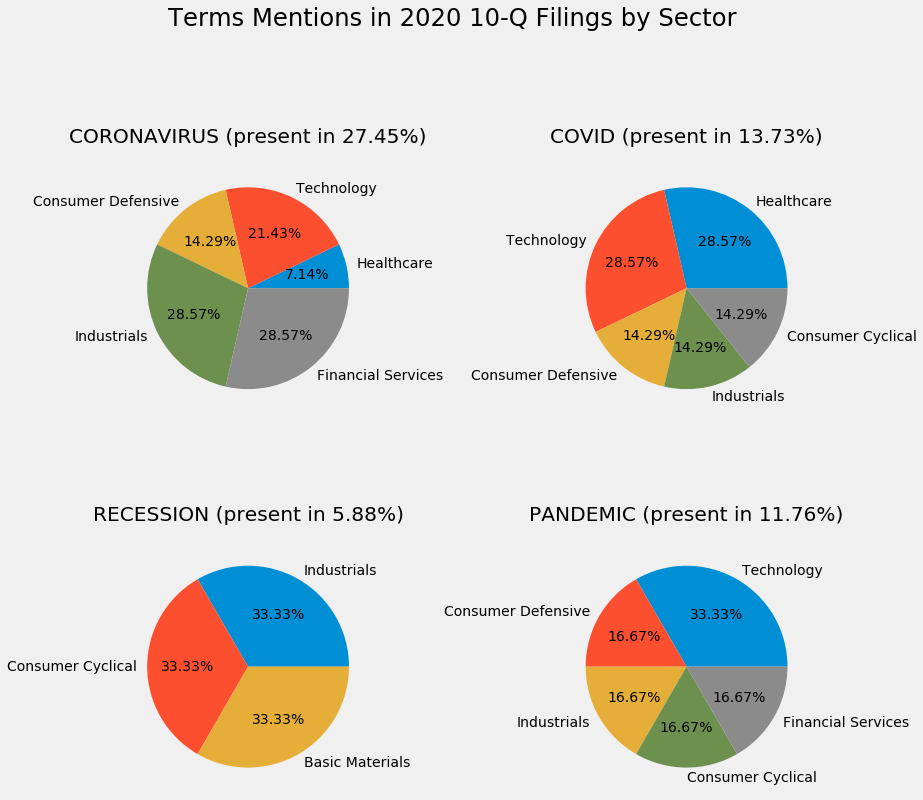

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

terms = ['coronavirus', 'covid', 'recession', 'pandemic']

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

recent_df = df_10Q.loc[df_10Q['date'] >= '01-01-2020']
for i, term in enumerate(terms):
    # Cumulative percent of mentions
    print('Term:', term.upper())
    cumPer = len(df_10Q.loc[df_10Q[term+'_present']]) / len(df_10Q)
    print(f'Percent mentioned: {100*cumPer:.2f}%')
    
    # Recent percent of mentions
    recentPer = len(recent_df.loc[recent_df[term+'_present']]) / len(recent_df)
    print(f'Percent mentioned (2020): {100*recentPer:.2f}%')
    
    # Sector makeup of recent mentions
    print('Sector breakdown:')
    sector_contribs = {}
    for sector in recent_df['sector'].unique():
        positive_mentions_df = recent_df.loc[recent_df[term+'_present']]
        sector_df = positive_mentions_df.loc[positive_mentions_df['sector'] == sector]
        percent = len(sector_df) / len(positive_mentions_df)
        print(f'\t {sector}: {100*percent:.2f}%', '('+str(len(sector_df))+')')
        
        sector_contribs[sector] = percent
    
    sector_contribs = {sector:percent for (sector, percent) in sector_contribs.items() if percent > 0}
    axs.reshape(-1)[i].pie(x=list(sector_contribs.values()), labels=list(sector_contribs.keys()), autopct='%.2f%%')
    axs.reshape(-1)[i].set_title(f'{term.upper()} (present in {100*recentPer:.2f}%)', pad=20)
    
fig.suptitle('Terms Mentions in 2020 10-Q Filings by Sector', size='xx-large')
plt.subplots_adjust(wspace=0, hspace=0.5, top=0.8)
plt.savefig(os.path.join(data_dir, 'imgs', 'piechart.png'))
plt.show()

## Sentiment

Text(0, 0.5, 'Sentiment')

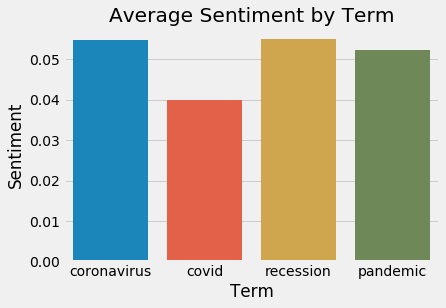

In [5]:
from textblob import TextBlob
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

terms = ['coronavirus', 'covid', 'recession', 'pandemic']

plt.style.use('fivethirtyeight')

term_sentiments = {}
for term in terms:
    term_filings = df_10Q.loc[df_10Q[term+'_present']]['diff']
    mean_sentiment = 0
    for filing in term_filings:
        mean_sentiment += TextBlob(filing).sentiment.polarity
    mean_sentiment /= len(term_filings)
    
    term_sentiments[term] = mean_sentiment
    
ax = sns.barplot(x=list(term_sentiments.keys()), y=list(term_sentiments.values()))
ax.set_title('Average Sentiment by Term')
ax.set_xlabel('Term')
ax.set_ylabel('Sentiment')

In [167]:
# Find average % of non-stop words are pos/neg
# Problem: negative terms are overrepresented in the dict
import pandas as pd
import os

fin_dicts = pd.read_excel(os.path.join(data_dir, 'FinSentLists.xlsx'), sheet_name=['Positive', 'Negative'], header=None)
pos_words = list(fin_dicts['Positive'][0].str.lower())
neg_words = list(fin_dicts['Negative'][0].str.lower())

In [7]:
print(len(neg_words) / len(pos_words))

6.6525423728813555


In [170]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))

terms = ['coronavirus', 'covid', 'recession', 'pandemic']

def remove_stopwords(filing):
    new_words = []
    for word in filing.split():
        if word not in stop_words:
            new_words.append(word)
    return ' '.join(new_words)

for term in terms:
    print(term.upper())
    term_df = df_10Q.loc[df_10Q[term+'_present']]
    for i, entry in term_df.iterrows():
        filing = remove_stopwords(entry['diff'])
        words = filing.split()
        pos_prop = len([word for word in words if word in pos_words]) / len(words)
        neg_prop = len([word for word in words if word in neg_words]) / len(words)
        print('\t', entry['name'])
        print(f'\tPos: {100*pos_prop:.2f}%')
        print(f'\tNeg: {100*neg_prop:.2f}%')

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CORONAVIRUS
	 BECTON DICKINSON & CO
	Pos: 1.07%
	Neg: 3.40%
	 Woodward, Inc.
	Pos: 0.99%
	Neg: 1.72%
	 CALAVO GROWERS INC
	Pos: 1.10%
	Neg: 1.47%
	 Toll Brothers, Inc.
	Pos: 0.53%
	Neg: 1.78%
	 ORACLE CORP
	Pos: 0.73%
	Neg: 2.18%
	 AeroVironment Inc
	Pos: 1.41%
	Neg: 2.25%
	 CROWN CRAFTS INC
	Pos: 0.72%
	Neg: 1.88%


KeyboardInterrupt: 

In [ ]:
# Do sentiment analysis only on sentences containing these words
# Each docs score will be the average of these
import spacy
from spacy.matcher import PhraseMatcher
from textblob import TextBlob

nlp = spacy.load('en_core_web_sm')
matcher = PhraseMatcher(nlp.vocab)
matcher.add('POSITIVE', [nlp(word) for word in pos_words])
matcher.add('NEGATIVE', [nlp(word) for word in neg_words])

In [ ]:
import numpy as np

for term in terms:
    term_df = df_10Q.loc[df_10Q[term+'_present']]
    
    for i, entry in term_df.iterrows():
        pos_sents = []
        neg_sents = []
        
        doc = nlp(entry['diff'])
        matches = matcher(doc)
        
        for match_id, start, end in matches:
            label = nlp.vocab.strings[match_id]
            if label == 'POSITIVE':
                pos_sents.append(doc[start:end].sent)
            elif label == 'NEGATIVE':
                neg_sents.append(doc[start:end].sent)
        
        mean_pos_sent_sentiment = 0
        pos_sent_l = []
        for sent in pos_sents:
            s = TextBlob(sent.text).sentiment.polarity
            pos_sent_l.append(s)
            mean_pos_sent_sentiment += s
        if len(pos_sents) > 0:
            mean_pos_sent_sentiment /= len(pos_sents)
        else:
            mean_pos_sent_sentiment = np.nan
        
        mean_neg_sent_sentiment = 0
        neg_sent_l = []
        for sent in neg_sents:
            s = TextBlob(sent.text).sentiment.polarity
            neg_sent_l.append(s)
            mean_neg_sent_sentiment += s
        if len(neg_sents) > 0:
            mean_neg_sent_sentiment /= len(neg_sents)
        else:
            mean_neg_sent_sentiment = np.nan
        
        print('meanPOS:', mean_pos_sent_sentiment)
        print('medianPOS:', np.median(pos_sent_l))
        print('meanNEG:', mean_neg_sent_sentiment)
        print('medianNEG:', np.median(neg_sent_l))

That didn't work very well either. I'll try using just the words from the financial terms dictionary to calculate sentiment as the difference ratio of pos/neg words

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
    
sentiment_list = []
for i, entry in df_10Q.iterrows():
    vctrzr = CountVectorizer()
    count_map = vctrzr.fit_transform([entry['diff']]).toarray()[0]
    
    pos_count = 0
    for pos_word in pos_words:
        try:
            pos_count += count_map[vctrzr.get_feature_names().index(pos_word)]
        except ValueError:
            pass
#             print('Token "', pos_word, '" not found in doc')

    neg_count = 0
    for neg_word in neg_words:
        try:
            neg_count += count_map[vctrzr.get_feature_names().index(neg_word)]
        except ValueError:
            pass
#             print('Token "', neg_word, '" not found in doc')

    sentiment = (2*pos_count - neg_count) / (2*pos_count + neg_count + 1e-10)
    sentiment_list.append(sentiment)

df_10Q['sentiment'] = sentiment_list

Text(0.5, 1.0, 'Sentiment Distribution')

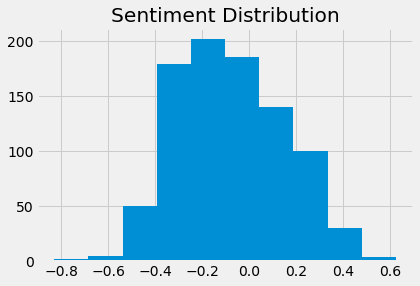

In [164]:
df_10Q['sentiment'].hist().set_title('Sentiment Distribution')

In [164]:
print('Overall mean sentiment:', df_10Q['sentiment'].mean())

for term in terms:
    term_df = df_10Q.loc[df_10Q[term+'_present']]
    print(term.upper(), 'sentiment mean:', term_df['sentiment'].mean())

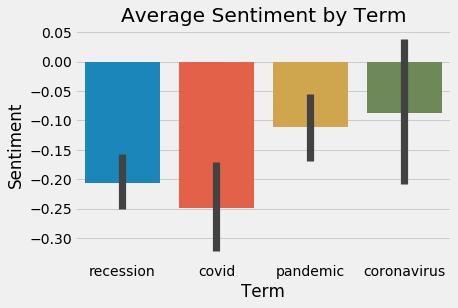

In [13]:
# This assumes no document mentions more than one unique term. This is not the case for at least document
def one_hot_to_term(entry):
    for term in terms:
        if entry[term+'_present']:
            return term

df_10Q['term'] = df_10Q.apply(lambda entry: one_hot_to_term(entry), axis=1)

ax = sns.barplot(x='term', y='sentiment', data=df_10Q)
ax.set_title('Average Sentiment by Term')
ax.set_xlabel('Term')
ax.set_ylabel('Sentiment')

plt.savefig(os.path.join(data_dir, 'barplots2.png'))

In [18]:
df_10Q['sector'].value_counts()

Financial Services        135
Technology                134
Consumer Cyclical         132
Industrials               121
Healthcare                108
Real Estate                71
Energy                     54
Consumer Defensive         52
Basic Materials            48
Utilities                  32
Communication Services     11
Name: sector, dtype: int64

In [19]:
recent_df = df_10Q.loc[df_10Q['date'] >= '2020-01-01']
recent_df['sector'].value_counts()

Industrials               11
Technology                11
Financial Services         9
Consumer Cyclical          6
Healthcare                 5
Consumer Defensive         4
Basic Materials            3
Communication Services     2
Name: sector, dtype: int64

In [21]:
tech = 3/11
print('tech', tech)
ind = 4/11
print('ind', ind)
health = 1/5
print('health', health)
con_def = 2/4
print('con_def', con_def)
fin = 4/9
print('fin', fin)

tech 0.2727272727272727
ind 0.36363636363636365
health 0.2
con_def 0.5
fin 0.4444444444444444


## Market Data

/home/zion/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

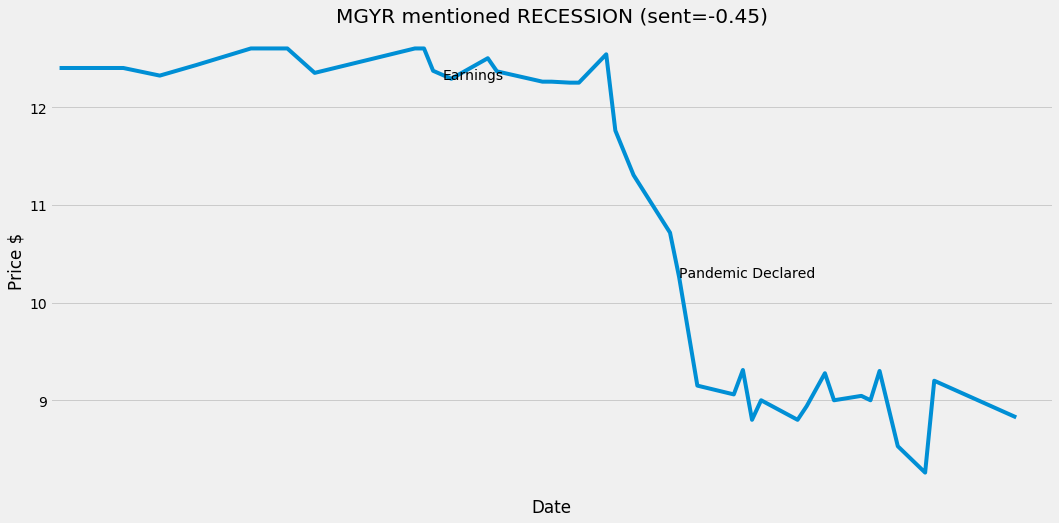

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

In [148]:
import alpaca_trade_api as trade_api
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
from datetime import datetime
import numpy as np
from adjustText import adjust_text

alpaca = trade_api.REST('AKKM2M8BDXOY29K2KQYD', 'DebMrSIcw33jd/nLaUyf2S6OTqU54/B90JSX5A30')
assets = alpaca.list_assets()
assets = [asset.symbol for asset in assets if asset._raw['class'] == 'us_equity']

months = mdates.MonthLocator()

price_change_dict = {}

terms = ['coronavirus', 'covid', 'recession', 'pandemic']
for term in terms:
    price_change_list = []
    
    term_df = df_10Q.loc[df_10Q[term+'_present']].loc[df_10Q['date'] >= '2020-01-01']
    symbols = list(term_df['ticker'])
    start = datetime(year=2020, month=1, day=1)
    end = datetime(year=2020, month=4, day=20)
    
    alpaca_time_fmt = '%Y-%m-%dT%H:%M:%S.%f-04:00'
    barset = alpaca.get_barset(symbols=symbols, timeframe='day', start=start.strftime(alpaca_time_fmt), end=end.strftime(alpaca_time_fmt))
    
    for ticker, bars in barset.items():
        if ticker not in assets:
            continue
        
        filtered_bars = list(filter(lambda bar: bar.t.date() >= start.date(), bars))
        if len(filtered_bars) == 0:
            continue
            
        timestamps = [bar.t.date() for bar in filtered_bars]
        closing_prices = [bar.c for bar in filtered_bars]
        
        # Plot
        fig = plt.figure(figsize=(16, 8))
        ax = sns.lineplot(timestamps, closing_prices)
        sent = df_10Q.loc[df_10Q['ticker'] == ticker].sort_values(by='date', ascending=False).iloc[0]['sentiment']
        ax.set_title(f'{ticker.upper()} mentioned {term.upper()} (sent={sent:.2f})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price $')
        ax.xaxis.set_major_locator(months)
        ax.set_xlim(start, end)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(months))

        # Annotate
        annots = []
        # - Earnings date
        earnings_date = term_df.loc[term_df['ticker'] == ticker]['date'].iloc[0].date()
        try:
            price_before_earnings = closing_prices[timestamps.index(earnings_date)-1]
            price_on_earnings = closing_prices[timestamps.index(earnings_date)]
            price_after_earnings = closing_prices[timestamps.index(earnings_date)+1]
            change = (price_after_earnings - price_before_earnings) / price_before_earnings
            price_change_dict[ticker] = change
            
        except ValueError:
            try:
                t_date = earnings_date + timedelta(days=1)
                price_on_earnings = closing_prices[timestamps.index(t_date)]
            except ValueError:
                t_date = earnings_date - timedelta(days=1)
                price_on_earnings = closing_prices[timestamps.index(t_date)]
        annots.append(ax.text(earnings_date, price_on_earnings, 'Earnings'))

        # - Pandemic declared
        pandemic_date = date(year=2020, month=3, day=10)
        try:
            price_on_pandemic = closing_prices[timestamps.index(pandemic_date)]
        except:
            continue
        annots.append(ax.text(pandemic_date, price_on_pandemic, 'Pandemic Declared'))

        # - New York shutdown
        ny_date = date(year=2020, month=3, day=20)
        try:
            price_on_ny_date = closing_prices[timestamps.index(ny_date)]
        except:
            continue
        annots.append(ax.text(ny_date, price_on_ny_date, 'NY Shuts Down'))
        
        x = [(timestamp - date(year=1, month=1, day=1)).days+1 for timestamp in timestamps]
        adjust_text(annots, x=x, y=closing_prices,only_move={'text': 'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=3))
        
        plt.savefig(os.path.join(data_dir, 'imgs', f'{term.upper()}({ticker})Bars.png'))
        plt.clf()

In [149]:
price_df = pd.DataFrame(columns=['ticker', 'price_change'])
price_df['ticker'] = price_change_dict.keys()
price_df['price_change'] = price_change_dict.values()

df_10Q = df_10Q.merge(price_df, how='outer', on='ticker')

In [140]:
# Get prices for remaining stocks
import alpaca_trade_api as trade_api
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
from datetime import datetime
import numpy as np
from adjustText import adjust_text

alpaca = trade_api.REST('AKKM2M8BDXOY29K2KQYD', 'DebMrSIcw33jd/nLaUyf2S6OTqU54/B90JSX5A30')
assets = alpaca.list_assets()
assets = [asset.symbol for asset in assets if asset._raw['class'] == 'us_equity']

months = mdates.MonthLocator()

price_change_dict = {}
date_dict = {}
    
start = datetime(year=2019, month=1, day=1)
end = datetime(year=2020, month=4, day=20)

alpaca_time_fmt = '%Y-%m-%dT%H:%M:%S.%f-04:00'

i = 0
incr = 100
while i < len(df_10Q):
    symbols = df_10Q['ticker'].iloc[i:i+incr]
    i += incr
    barset = alpaca.get_barset(symbols=symbols, timeframe='day', start=start.strftime(alpaca_time_fmt), end=end.strftime(alpaca_time_fmt))
    
    for ticker, bars in barset.items():
        if ticker not in assets:
            continue

        filtered_bars = list(filter(lambda bar: bar.t.date() >= start.date(), bars))
        if len(filtered_bars) == 0:
            continue

        timestamps = [bar.t.date() for bar in filtered_bars]
        
        closing_prices = [bar.c for bar in filtered_bars]
        # - Earnings date
        earnings_date = df_10Q.loc[df_10Q['ticker'] == ticker]['date'].iloc[0].date()
        try:
            price_before_earnings = closing_prices[timestamps.index(earnings_date)-1]
            price_on_earnings = closing_prices[timestamps.index(earnings_date)]
            price_after_earnings = closing_prices[timestamps.index(earnings_date)+1]
            change = (price_after_earnings - price_before_earnings) / price_before_earnings
            price_change_dict[ticker] = change
            date_dict[ticker] = earnings_date

        except ValueError:
            try:
                t_date = earnings_date + timedelta(days=1)
                price_before_earnings = closing_prices[timestamps.index(t_date)-1]
                price_on_earnings = closing_prices[timestamps.index(t_date)]
                price_after_earnings = closing_prices[timestamps.index(t_date)+1]
                change = (price_after_earnings - price_before_earnings) / price_before_earnings
                price_change_dict[ticker] = change
                date_dict[ticker] = earnings_date
            except ValueError:
                try:
                    t_date = earnings_date - timedelta(days=1)
                    price_before_earnings = closing_prices[timestamps.index(t_date)-1]
                    price_on_earnings = closing_prices[timestamps.index(t_date)]
                    price_after_earnings = closing_prices[timestamps.index(t_date)+1]
                    change = (price_after_earnings - price_before_earnings) / price_before_earnings
                    price_change_dict[ticker] = change
                    date_dict[ticker] = earnings_date
                except Exception as e:
                    print(e)
                    continue

price_df = pd.DataFrame(columns=['ticker', 'price_change', 'date'])
price_df['ticker'] = price_change_dict.keys()
price_df['ticker'] = price_df['ticker'].astype(str)
price_df['price_change'] = price_change_dict.values()
price_df['date'] = date_dict.values()
price_df['date'] = pd.to_datetime(price_df['date'])

df_10Q = df_10Q.merge(price_df, how='outer', on=['ticker', 'date'])

datetime.date(2019, 8, 7) is not in list
datetime.date(2019, 5, 14) is not in list
datetime.date(2019, 12, 18) is not in list


In [150]:
recent_df = df_10Q.loc[df_10Q['date'] >= '2020-01-01']
recent_df.corr()['sentiment']

cik                   -0.211027
marketcap             -0.027723
corona_present         0.034602
virus_present         -0.004604
covid_present         -0.143093
recession_present     -0.049049
pandemic_present       0.126336
coronavirus_present    0.021487
sentiment              1.000000
price_change          -0.002922
Name: sentiment, dtype: float64

In [151]:
recent_df['price_change'].count()

15

Intercept    0.194562
sentiment    0.991755
dtype: float64


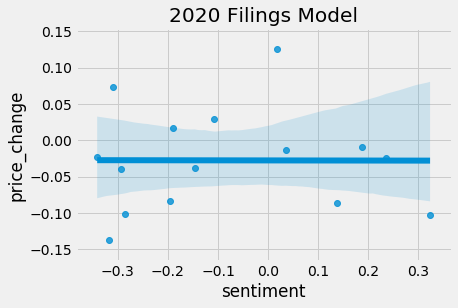

In [153]:
# Check if the relationship between sentiment and price change is significant
import statsmodels.formula.api as smf

sns.regplot(x='sentiment', y='price_change', data=recent_df).set_title('2020 Filings Model')

lm = smf.ols(formula='price_change~sentiment', data=recent_df).fit()
print(lm.pvalues)
plt.savefig(os.path.join(data_dir, 'imgs', '2020FilingsModel.png'))

### Read

In [162]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

matcher = Matcher(nlp.vocab)

terms = ['coronavirus', 'covid', 'recession', 'pandemic']
pattern = [[{'LEMMA': term.lower()}] for term in terms]
matcher.add('Terms', pattern)

recent_df = df_10Q.loc[df_10Q['date'] >= '2020-01-01']
for i, row in recent_df.iterrows():    
    doc = nlp(row['diff'])
    matches = matcher(doc)
    
    if matches:
        print('Company:', row['name'], row['date'])
        for match_id, start, end in matches:
            span = doc[start:end]
            sent = span.sent
            print(sent.text)
            print()
        print()

Company: BECTON DICKINSON & CO 2020-02-06 00:00:00
natural disasters (including pandemics), war, terrorism, labor disruptions and international conflicts that could cause significant economic disruption and political and social instability, resulting in decreased demand for our products, adversely affect our manufacturing and distribution capabilities, or cause interruptions in our supply chain.


recently, a strain of coronavirus was reported in china and the virus has begun to spread to other countries.  



Company: Woodward, Inc. 2020-02-10 00:00:00
our operations and suppliers be subject to physical and other risks, including natural disasters, epidemics, pandemics, and other catastrophic events beyond our control, which could disrupt production and have a material adverse effect on our business, financial condition, results of operations and cash flows.



public health concerns, including epidemics or pandemics, such as the coronavirus, or natural disasters, war, political unres